In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=128)
parser.add_argument("--lr", type=float, default=5e-6)
parser.add_argument("--num_epochs", type=int, default=200)
parser.add_argument("--num_workers", type=int, default=70)
parser.add_argument("--num_decoder_layers", type=int, default=3)

# accept all othjer arguments even if it is not listed here
parser.add_argument("--", dest="others", nargs=argparse.REMAINDER)
args, unknown = parser.parse_known_args()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2
import torchvision.transforms.functional

import numpy as np
import cv2
import os
import cv2 as cv
import matplotlib.pyplot as plt
import random

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, mode="train"):
        self.mode = mode
        self.datapath = "/home/wg25r/fastdata/CDNet"
       
        if mode == "train":
            with open(f"{self.datapath}/train.txt") as f:
                self.images = f.read().split("\n")
        else: 
            with open(f"{self.datapath}/val.txt") as f:
                self.images = f.read().split("\n")
            self.images = random.sample(self.images, 128)


        self.ignore_after = 40 
        self.space_trans = torchvision.transforms.v2.Compose([
            torchvision.transforms.v2.RandomResizedCrop(448, scale=(0.6, 3)), 
            torchvision.transforms.v2.RandomHorizontalFlip(0.5),
            torchvision.transforms.v2.RandomRotation(20), 
            torchvision.transforms.v2.RandomApply(
                [torchvision.transforms.v2.ElasticTransform(alpha=50)], p=0.2
            ),
            torchvision.transforms.v2.RandomApply(
                [torchvision.transforms.v2.RandomPerspective()], p=0.2
            ),
            torchvision.transforms.v2.RandomApply(
                [torchvision.transforms.v2.RandomAffine(20,  scale=(0.5, 1.1))], p=0.2
            ),
        ])
        self.color_trans = torchvision.transforms.v2.Compose([
            torchvision.transforms.v2.RandomApply([torchvision.transforms.v2.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.4)
        ])

    def __len__(self): 
        if self.mode == "train":
            return int(len(self.images)) 
        else: 
            return int(len(self.images))
        

    def __getitem__(self, idx):  
        filename = self.images[idx]

        current_frame = cv2.resize(cv2.imread(f"{self.datapath}/in/{filename}"), (448, 448))
        long_bg = cv2.resize(cv2.imread(f"{self.datapath}/long/{filename}"), (448, 448))
        short_bg = cv2.resize(cv2.imread(f"{self.datapath}/short/{filename}"), (448, 448)) 
        label_ = cv2.imread(f"{self.datapath}/gt/{filename}")
        label = (label_ == 255) * 255.0
        ROI =  (label_ != 85) * 255.0
        label = cv2.resize(label, (448, 448))
        ROI = cv2.resize(ROI, (448//4, 448//4)).mean(-1) > 0
        ROI = torch.tensor(ROI).float()

        current_frame = torch.tensor(current_frame).permute(2,0,1)
        long_bg = torch.tensor(long_bg).permute(2,0,1)
        short_bg = torch.tensor(short_bg).permute(2,0,1)
        label = torch.tensor(label).permute(2,0,1)
        X = torch.cat([current_frame, long_bg, short_bg], axis=0)
        # print(X.shape)
        
        Y = label.max(0)[0][None,:,:] 

        if self.mode == "train":  
            # X = self.color_trans(X) 
            YX = torch.cat((Y, X), axis=0) 
            YX = self.space_trans(YX)
            Y = YX[:1]/255.0  
            X = YX[1:]/255.0 
            X += torch.randn(X.shape) * 0.005
            X += torch.tensor(cv.resize(np.random.normal(0, 0.005, (10, 10)), X.shape[1:])).float()
            X *= 1 + torch.randn(9)[:,None,None] * 0.005
        else:
            X = X/255.0
            Y = Y/255.0 
        Y = torchvision.transforms.functional.resize(Y, (448//4, 448//4))[0] > 0
        Y = Y.float() #if not this loss will be issue, maybe from the resize, identical not 0
        X[X<0]=0
        # print(X.shape, Y.shape, ROI.shape)
        return X, Y, ROI 


In [3]:
vits8 = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')

# %%
class BCA(nn.Module):
    """
    Background-CurrentFrame Attention
    """
    def __init__(self, dim=384):
        super(BCA, self).__init__()
        self.cross_attention = nn.MultiheadAttention(dim, HEADS, dropout=0.1, batch_first=True, kdim=dim, vdim=dim * 2)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, dim)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
    
    def forward(self, long_background, short_background, current_frame):
        """
        long_background: torch.Tensor, shape (batch, L, dim)
        short_background: torch.Tensor, shape (batch, L, dim)
        current_frame: torch.Tensor, shape (batch, L, dim)
        """

        # first do cross attention between current_frame and long_background
        attn_output, _ = self.cross_attention(query=current_frame, key=long_background, value=torch.concatenate([long_background, current_frame], dim=-1))
        attn_output = self.norm1(attn_output + current_frame)
        mlp_output = self.mlp(attn_output)
        mlp_output = self.norm2(mlp_output + attn_output)

        # then do cross attention between mlp output and short_background
        attn_output, _ = self.cross_attention(query=mlp_output, key=short_background, value=torch.concatenate([short_background, mlp_output], dim=-1))
        attn_output = self.norm1(attn_output + mlp_output)
        mlp_output = self.mlp(attn_output)
        mlp_output = self.norm2(mlp_output + attn_output)
        return mlp_output
    
        

# %%
class BCA_lite(nn.Module):
    """
    Background-CurrentFrame Attention
    """
    def __init__(self, dim=384):
        super(BCA_lite, self).__init__()
        self.dim = dim
        self.key_projection = nn.Linear(dim, dim)
        self.query_projection = nn.Linear(dim, dim)
        self.value_projection = nn.Linear(dim * 2, dim)
        self.mlp = nn.Sequential(
            nn.Linear(2 * dim, 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.Dropout(0.2),
            nn.ReLU(), 
            nn.Linear(2048, dim),
            nn.Dropout(0.2)
        )
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, current_frame, long_background, short_background):
        """
        long_background: torch.Tensor, shape (batch, L, dim)
        short_background: torch.Tensor, shape (batch, L, dim)
        current_frame: torch.Tensor, shape (batch, L, dim)
        """

        # long background attention with frame
        key = self.key_projection(long_background)
        query = self.query_projection(current_frame)
        value = self.value_projection(torch.concatenate([long_background, current_frame], dim=-1))

        attn_score = torch.einsum("bld,bld->bl", query, key) / self.dim**0.5
        attn_score = F.softmax(attn_score, dim=1)
        attn_output = torch.einsum("bl,bld->bld", attn_score, value)
        attn_output = self.norm1(attn_output + current_frame) 
        mlp_output = self.mlp(torch.concatenate([attn_output, current_frame], dim=-1))
        mlp_output = self.norm2(mlp_output + attn_output)

        # short background attention with frame
        key = self.key_projection(short_background)
        query = self.query_projection(current_frame)
        value = self.value_projection(torch.concatenate([short_background, current_frame], dim=-1))

        attn_score = torch.einsum("bld,bld->bl", query, key) / self.dim**0.5
        attn_score = F.softmax(attn_score, dim=1)
        attn_output = torch.einsum("bl,bld->bld", attn_score, value)
        attn_output = self.norm1(attn_output + mlp_output)
        mlp_output = self.mlp(torch.concatenate([attn_output, mlp_output], dim=-1))
        mlp_output2 = self.norm2(mlp_output + attn_output)
        return torch.cat([mlp_output, mlp_output2], dim=-1)
    
        
        

last_n = 1    

# %%
class MyModel(nn.Module):
    def __init__(self, backbone):
        super(MyModel, self).__init__()
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.bca = BCA_lite()
        self.decoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=384 * 2, nhead=8, dim_feedforward=1024, dropout=0.2, batch_first=True),
            num_layers=args.num_decoder_layers
        )
        self.head = nn.Sequential(
            nn.Conv2d(384 * 2, 32, 1),
            nn.Dropout(0.2), 
            nn.ReLU(),
            nn.Conv2d(32, 1, 1),
            nn.Upsample(scale_factor=2, mode='bicubic'),
        )   
        

    def forward(self, current_frame, long_bg, short_bg):
        long_bg = self.backbone.get_intermediate_layers(long_bg, n=last_n)
        short_bg = self.backbone.get_intermediate_layers(short_bg, n=last_n)
        current_frame = self.backbone.get_intermediate_layers(current_frame, n=last_n)
        # print(last_n)
        res = torch.zeros((long_bg[0].shape[0], 448//8 * 448//8, 384 * 2)).to(long_bg[0].device)
        # print(long_bg[0].shape, short_bg[0].shape, current_frame[0].shape)
        for layer in range(last_n): 
            current_frame = self.bca(current_frame[layer][:,1:,:], long_bg[layer][:,1:,:], short_bg[layer][:,1:,:])
            current_frame = self.decoder(current_frame)
            res = current_frame + res
        current_frame = res/last_n 

        return self.head(current_frame.reshape(long_bg[0].shape[0], 448//8, 448//8, 384 * 2).permute(0,3,1,2))
    

Using cache found in /home/wg25r/.cache/torch/hub/facebookresearch_dino_main


In [4]:
with open("/home/wg25r/fastdata/CDNet/val.txt", "r") as f:
    val_files = f.read().split("\n")

In [28]:
val_files = os.listdir("/home/wg25r/fastdata/gasvid/train/images")
val_list = [i for i in sorted(val_files) if i.startswith("train_1240_00004")]

In [29]:
frames = []
long_bg = []
short_bg = []
for i in val_list:
    frames.append(cv2.resize(cv2.imread(f"/home/wg25r/fastdata/gasvid/train/images/{i}"), (448, 448)))
    long_bg.append(cv2.resize(cv2.imread(f"/home/wg25r/fastdata/gasvid/train/ir_background/{i}"), (448, 448)))
    short_bg.append(cv2.resize(cv2.imread(f"/home/wg25r/fastdata/gasvid/train/ir_background/{i}"), (448, 448)))

In [30]:
model = MyModel(vits8) 
model = nn.DataParallel(model) 
model.load_state_dict(torch.load(f"main.pth"))

/tmp/ipykernel_289212/3560680610.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"main.pth"))


<All keys matched successfully>

In [31]:
# write to mp4
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (448 * 3, 448))
import tqdm
flatten_pred = []
flatten_gt = []
model = model.eval()
for frame_id in tqdm.tqdm(range(1, len(val_list), 10)):
    # print(frame_id)
    current_frame = torch.tensor(frames[frame_id]).permute(2,0,1).unsqueeze(0).float() / 255.0
    long_bg_frame = torch.tensor(long_bg[frame_id]).permute(2,0,1).unsqueeze(0).float() / 255.0
    short_bg_frame = torch.tensor(short_bg[frame_id]).permute(2,0,1).unsqueeze(0).float() / 255.0
    gt_frame = cv2.resize(cv2.imread(f"/home/wg25r/fastdata/gasvid/train/masks/{val_list[frame_id].replace('jpg','png')}"), (448, 448))/255.0
    with torch.no_grad():
        pred = model(current_frame, long_bg_frame, short_bg_frame) 
    pred = pred[0,0].cpu().numpy() > 0 
    pred = 1.0 * pred
    # show 3 side by side with label using cv2 
    pred = cv2.resize(pred, (gt_frame.shape[1], gt_frame.shape[0]))
    current_frame = current_frame[0].permute(1,2,0).cpu().numpy()   
    pred = pred[None,:,:].repeat(3, axis=0).transpose(1,2,0)
    res = np.concatenate([current_frame, pred, gt_frame], axis=1)
    out.write((res * 255).astype(np.uint8))
    flatten_pred.append(pred)
    flatten_gt.append(gt_frame)
    
out.release()


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


In [32]:
flatten_pred = np.concatenate(flatten_pred, axis=0)
flatten_gt = np.concatenate(flatten_gt, axis=0)

In [33]:
flatten_pred = np.float32(flatten_pred)>0
flatten_gt = np.float32(flatten_gt)>0

# sklearn F1 score
from sklearn.metrics import f1_score
flatten_pred = flatten_pred.flatten()
flatten_gt = flatten_gt.flatten()
f1_score(flatten_gt, flatten_pred)



np.float64(0.0)

In [34]:
# iou between pred and gt 
iou = (((pred > 0) & (gt_frame > 0)).astype(float).mean() + 1e-6)/(((pred > 0) | ((gt_frame > 0))).astype(float).mean() + 1e-6)
iou

np.float64(1.3538942436595872e-05)

In [35]:
iou 

np.float64(1.3538942436595872e-05)

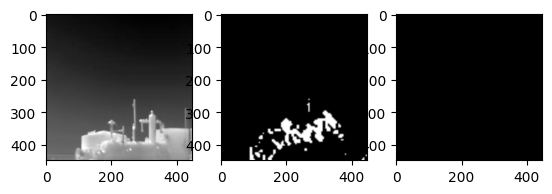

In [36]:
import pylab
pylab.subplot(1, 3, 1)
pylab.imshow(current_frame)
pylab.subplot(1, 3, 2)
pylab.imshow(pred) 
pylab.subplot(1, 3, 3) 
pylab.imshow(gt_frame)

In [37]:
np.abs(long_bg_frame.permute(0,2,3,1)[0].numpy() - current_frame).max()

np.float32(0.10588235)

In [38]:
current_frame.shape, pred.shape, gt_frame.shape

((448, 448, 3), (448, 448, 3), (448, 448, 3))